<a href="https://colab.research.google.com/github/mohannashahrad/Borealis_AI_Plant_Tree_Project/blob/main/Training/Analysis_Tree_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [76]:
# Imort all the required libraries
import pandas as pd
import requests
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import numpy as np
from sklearn.linear_model import LinearRegression  
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer    
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
import xgboost as xgb

#Defining Functions


In [77]:
# Functions
def load_DF(url):
  data = StringIO(requests.get(url).text)
  return pd.read_csv(data)

def standardize(df,col_names):
  print(type(df))
  df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
  df.reset_index(inplace=True, drop=True)
  features = df[col_names]
  scaler = StandardScaler().fit(features.values)
  features = scaler.transform(features.values)
  df[col_names] = features
  return df

def oneHotEncode(df, discrete_columns):
  for var in discrete_columns:
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_df = pd.DataFrame(enc.fit_transform(df[[var]]).toarray())
    enc_df.columns = enc.get_feature_names([var])
    df = df.join(enc_df)
    df = df.drop([var], axis=1)
  return df

#Loading the Dataset

In [78]:
# Loading DataSet
df = load_DF('https://raw.githubusercontent.com/mohannashahrad/Borealis_AI_Plant_Tree_Project/main/Final_Data/final_data2.csv')
df = df.iloc[: , 1:]
display(df.head())

,Time,Country Name,Land Area (m2),Agriculture Land (m2),Forest Land (m2),Population,Pop Growth (%),Urban Pop (%),GDP (US$),GDP Growth (%),Forest Rents (% GDP),Coal Rents (% GDP),Oil Rents (% GDP),CO2 Emission (kt),GHG Emision (CO2 eqv),Tree Loss (ha)
0,2001,Afghanistan,652860.0,377530.0,12084.4,21606992.0,3.902805,22.169,NaN,NaN,NaN,NaN,NaN,810.0,13490.0,88.092712
1,2002,Afghanistan,652860.0,377530.0,12084.4,22600774.0,4.496719,22.261,4.055180e+09,NaN,0.958004,0.004341,0.029101,1100.0,16090.0,178.640364
2,2003,Afghanistan,652860.0,379100.0,12084.4,23680871.0,4.668344,22.353,4.515559e+09,8.832278,0.664331,0.007422,0.026686,1350.0,16780.0,244.336255
3,2004,Afghanistan,652860.0,379110.0,12084.4,24726689.0,4.321560,22.500,5.226779e+09,1.414118,0.387787,0.016455,0.025399,1130.0,16520.0,201.444959
4,2005,Afghanistan,652860.0,379100.0,12084.4,25654274.0,3.682700,22.703,6.209138e+09,11.229715,0.332205,0.010904,0.025973,1640.0,17400.0,235.956834


#Preprocessing 

This section consists of data normalization and one-hot encoding for discrete features.

In [79]:
col_names = ['Land Area (m2)', 'Agriculture Land (m2)', 'Forest Land (m2)', 'Population', 'Pop Growth (%)', 'Urban Pop (%)',
                'GDP (US$)', 'GDP Growth (%)', 'Forest Rents (% GDP)', 'Coal Rents (% GDP)', 'Oil Rents (% GDP)', 'CO2 Emission (kt)',
                'GHG Emision (CO2 eqv)', 'Tree Loss (ha)']

df = standardize(df,col_names)
discrete_columns = ["Country Name"]
df = oneHotEncode(df,discrete_columns)
df.head(30)

<class 'pandas.core.frame.DataFrame'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,Time,Land Area (m2),Agriculture Land (m2),Forest Land (m2),Population,Pop Growth (%),Urban Pop (%),GDP (US$),GDP Growth (%),Forest Rents (% GDP),Coal Rents (% GDP),Oil Rents (% GDP),CO2 Emission (kt),GHG Emision (CO2 eqv),Tree Loss (ha),Country Name_Afghanistan,Country Name_Albania,Country Name_Algeria,Country Name_Angola,Country Name_Antigua and Barbuda,Country Name_Argentina,Country Name_Armenia,Country Name_Australia,Country Name_Austria,Country Name_Azerbaijan,"Country Name_Bahamas, The",Country Name_Bangladesh,Country Name_Barbados,Country Name_Belarus,Country Name_Belgium,Country Name_Belize,Country Name_Benin,Country Name_Bhutan,Country Name_Bolivia,Country Name_Bosnia and Herzegovina,Country Name_Botswana,Country Name_Brazil,Country Name_Brunei Darussalam,Country Name_Bulgaria,Country Name_Burkina Faso,...,Country Name_Senegal,Country Name_Serbia,Country Name_Seychelles,Country Name_Sierra Leone,Country Name_Singapore,Country Name_Slovak Republic,Country Name_Slovenia,Country Name_Solomon Islands,Country Name_South Africa,Country Name_South Sudan,Country Name_Spain,Country Name_Sri Lanka,Country Name_St. Kitts and Nevis,Country Name_St. Lucia,Country Name_St. Vincent and the Grenadines,Country Name_Sudan,Country Name_Suriname,Country Name_Sweden,Country Name_Switzerland,Country Name_Syrian Arab Republic,Country Name_Tajikistan,Country Name_Tanzania,Country Name_Thailand,Country Name_Timor-Leste,Country Name_Togo,Country Name_Trinidad and Tobago,Country Name_Tunisia,Country Name_Turkey,Country Name_Turkmenistan,Country Name_Uganda,Country Name_Ukraine,Country Name_United Kingdom,Country Name_United States,Country Name_Uruguay,Country Name_Uzbekistan,Country Name_Vanuatu,"Country Name_Venezuela, RB",Country Name_Vietnam,Country Name_Zambia,Country Name_Zimbabwe
0,2003,-0.053191,0.151565,-0.280729,-0.121892,2.833507,-1.488437,-0.252053,0.966200,-0.325614,-0.195424,-0.367831,-0.225766,-0.238114,-0.266975,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2004,-0.053191,0.151580,-0.280729,-0.114761,2.540205,-1.481744,-0.251572,-0.476629,-0.391587,-0.185539,-0.367980,-0.226046,-0.238385,-0.267067,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2005,-0.053191,0.151565,-0.280729,-0.108437,1.999872,-1.472501,-0.250907,1.432500,-0.404847,-0.191614,-0.367914,-0.225396,-0.237467,-0.266993,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2006,-0.053191,0.151565,-0.280729,-0.103127,1.414446,-1.463213,-0.250391,0.290338,-0.375773,-0.191342,-0.368358,-0.225013,-0.233669,-0.267173,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2007,-0.053191,0.151565,-0.280729,-0.098576,0.994354,-1.453834,-0.248513,1.937539,-0.402332,-0.119929,-0.369223,-0.224477,-0.229663,-0.266957,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2008,-0.053191,0.151565,-0.280729,-0.094337,0.803583,-1.444410,-0.248268,0.011733,-0.399720,0.042073,-0.369056,-0.221887,-0.222715,-0.267268,1.0,0.0,0.0,0.0,0

# Splitting the dataset into test and train sets

In [80]:
# Splitting the dataset into training and test parts
y = df['Tree Loss (ha)']
x = df.loc[:, df.columns != 'Tree Loss (ha)']
x = x[~x.isin([np.nan, np.inf, -np.inf]).any(1)]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)

(2296, 184)
(574, 184)


# First Model: Linear Regression

In [55]:
model = LinearRegression()  
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
compare_df = pd.DataFrame({'Actual': y_test.to_numpy().flatten(), 'Predicted': y_pred.flatten()})
display(compare_df)

,Actual,Predicted
0,-0.232468,-0.248543
1,-0.143533,-0.223096
2,-0.265565,-0.185945
3,-0.053717,-0.144712
4,-0.162257,-0.167561
...,...,...
569,-0.253234,-0.247752
570,-0.250942,-0.266204
571,0.276139,0.144419
572,-0.262704,-0.181330


In [56]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 score:', np.sqrt(metrics.r2_score(y_pred,y_test)))

Mean Absolute Error: 0.08735381544979458
Mean Squared Error: 0.06848512852413526
Root Mean Squared Error: 0.261696634529631
R2 score: 0.9445871374707997


#Second Model: XGBoost

In [85]:
dtrain = xgb.DMatrix(data=X_train,label=y_train)
params = {
    'gamma':0,                 
    'learning_rate':0.07,
    'max_depth':5,
    'min_child_weight':1.5,
    'n_estimators':1000,                                                                    
    'reg_alpha':0.75,
    'reg_lambda':0.45,
    'subsample':0.6,
    'seed':42
}
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=999,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,0.754125,0.003199,0.754515,0.011165
1,0.703399,0.003076,0.703990,0.009387
2,0.656228,0.002753,0.657055,0.008689
3,0.612665,0.002643,0.613254,0.007689
4,0.572292,0.002624,0.572965,0.006741
...,...,...,...,...
820,0.016041,0.000360,0.067821,0.014679
821,0.016032,0.000360,0.067815,0.014677
822,0.016026,0.000358,0.067814,0.014678
823,0.016023,0.000360,0.067805,0.014676


#Hyper parameter Tuning for XGBoost

In [87]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(4,10)
    for min_child_weight in range(1,8)
]

min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=1000,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=4, min_child_weight=1
	MAE 0.0691244 for 701 rounds
CV with max_depth=4, min_child_weight=2
	MAE 0.0701694 for 664 rounds
CV with max_depth=4, min_child_weight=3
	MAE 0.0699388 for 664 rounds
CV with max_depth=4, min_child_weight=4
	MAE 0.07205099999999999 for 855 rounds
CV with max_depth=4, min_child_weight=5
	MAE 0.07174720000000001 for 662 rounds
CV with max_depth=4, min_child_weight=6
	MAE 0.0719934 for 897 rounds
CV with max_depth=4, min_child_weight=7
	MAE 0.08141899999999999 for 311 rounds
CV with max_depth=5, min_child_weight=1
	MAE 0.06781380000000001 for 441 rounds
CV with max_depth=5, min_child_weight=2
	MAE 0.06779919999999999 for 824 rounds
CV with max_depth=5, min_child_weight=3
	MAE 0.069769 for 495 rounds
CV with max_depth=5, min_child_weight=4
	MAE 0.0697574 for 824 rounds
CV with max_depth=5, min_child_weight=5
	MAE 0.0703186 for 583 rounds
CV with max_depth=5, min_child_weight=6
	MAE 0.0762888 for 245 rounds
CV with max_depth=5, min_child_weight=7
	

In [95]:
data_dmatrix = xgb.DMatrix(data=x,label=y)
xg_reg = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=8,
                 min_child_weight=3,
                 n_estimators=1000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
xg_reg.fit(X_train,y_train)

y_pred = xg_reg.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

[19:15:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error: 0.058673878637663726
Mean Squared Error: 0.058537987498381405
Root Mean Squared Error: 0.24194624919262833
R2 score: 0.9522345367327252


In [36]:
compare_df = pd.DataFrame({'Actual': y_test.to_numpy().flatten(), 'Predicted': y_pred.flatten()})
display(compare_df)

,Actual,Predicted
0,-0.232468,-0.245290
1,-0.143533,-0.231108
2,-0.265565,-0.265650
3,-0.053717,-0.050834
4,-0.162257,-0.180246
...,...,...
569,-0.253234,-0.260278
570,-0.250942,-0.251591
571,0.276139,0.210067
572,-0.262704,-0.142116


#Feature Importance using XGBoost

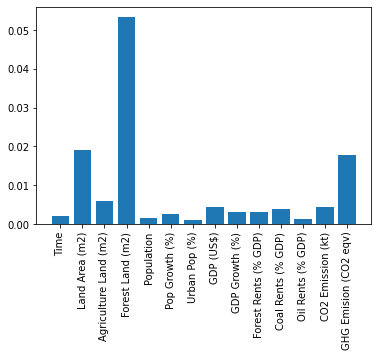

In [96]:
pyplot.bar(range(14), xg_reg.feature_importances_[:14])
LABELS = x.columns[:14]
pyplot.xticks(range(len(xg_reg.feature_importances_[:14])), LABELS, rotation='vertical')
pyplot.show()

#Third Model: LightGBM

In [74]:
import lightgbm as lgb

def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y_true + 1) - np.log1p(y_pred + 1), 2)))
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmsle',
    'max_depth': 6, 
    'learning_rate': 0.1,
    'verbose': 0}
n_estimators = 100

n_iters = 5
preds_buf = []
err_buf = []
X_lgb = X_train
y_lgb = y_train
for i in range(n_iters): 
    x_train, x_valid, y_train, y_valid = train_test_split(X_lgb, y_lgb, test_size=0.10, random_state=i)
    d_train = lgb.Dataset(x_train, label=y_train)
    d_valid = lgb.Dataset(x_valid, label=y_valid)
    watchlist = [d_valid]

    model = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=1)

    preds = np.exp(model.predict(x_valid)) - 1
    err = rmsle(np.exp(y_valid) - 1, preds)
    err_buf.append(err)
    print('RMSLE = ' + str(err))
    
    preds = np.exp(model.predict(X_test)) - 1
    preds_buf.append(preds)

print('Mean RMSLE = ' + str(np.mean(err_buf)) + ' +/- ' + str(np.std(err_buf)))
preds = np.mean(preds_buf, axis=0)
compare_df = pd.DataFrame({'Actual': y_test.to_numpy().flatten(), 'Predicted': preds.flatten()})
display(compare_df)

RMSLE = 0.5735828286830064
RMSLE = 0.24590459141015775
RMSLE = 0.12682682159660605
RMSLE = 0.10453368902332255
RMSLE = 0.2073689065374651
RMSLE = 0.32544104491493214
RMSLE = 0.2628590957597385
RMSLE = 0.39136852582428333
RMSLE = 0.34926256614680673
RMSLE = 0.11541690574622619
Mean RMSLE = 0.27025649756425446 +/- 0.13877185812822124


,Actual,Predicted
0,-0.232468,-0.197738
1,-0.143533,-0.145500
2,-0.265565,-0.218526
3,-0.053717,-0.006358
4,-0.162257,-0.135388
...,...,...
569,-0.253234,-0.229833
570,-0.250942,-0.225757
571,0.276139,0.198373
572,-0.262704,-0.125056


#Feature Importance using LightGBM


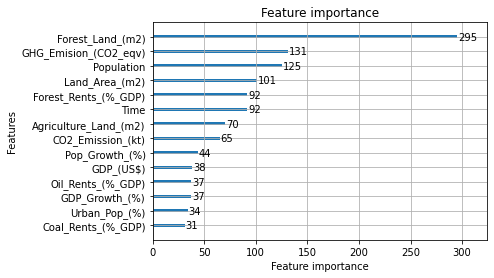

In [75]:
lgb.plot_importance(model)